In [2]:
# Import Required Libraries
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Load Metadata CSV

In [4]:
# Load the metadata CSV
csv_file = Path("E:\\speech-emotion-gradcam\\text_analysis\\tess_metadata.csv")

if not Path.exists(csv_file):
    print(f"Error: tess_metadata.csv not found!")
else:
    df = pd.read_csv(csv_file)
    print(f"Loaded {len(df)} records from {csv_file}")
    print(f"\nDataFrame shape: {df.shape}")
    print(f"\nFirst 5 rows:")
    print(df.head())

Loaded 2800 records from E:\speech-emotion-gradcam\text_analysis\tess_metadata.csv

DataFrame shape: (2800, 4)

First 5 rows:
                                                Path Speaker Emotion  \
0  /content/drive/MyDrive/speech_emotion_project/...     OAF    Fear   
1  /content/drive/MyDrive/speech_emotion_project/...     OAF    Fear   
2  /content/drive/MyDrive/speech_emotion_project/...     OAF    Fear   
3  /content/drive/MyDrive/speech_emotion_project/...     OAF    Fear   
4  /content/drive/MyDrive/speech_emotion_project/...     OAF    Fear   

              Transcript  
0     Say the word back.  
1      Say the word bar.  
2     Say the word base.  
3     Say the word bath.  
4  Say the word being...  


## Data Exploration

In [5]:
# Check for missing data
print("Missing values:")
print(df.isnull().sum())
print(f"\nData types:")
print(df.dtypes)

Missing values:
Path          0
Speaker       0
Emotion       0
Transcript    0
dtype: int64

Data types:
Path          object
Speaker       object
Emotion       object
Transcript    object
dtype: object


In [6]:
# Filter for valid transcripts
df_clean = df[df['Transcript'].notna() & (df['Transcript'].str.len() > 0)].copy()
print(f"Total records: {len(df)}")
print(f"Records with valid transcripts: {len(df_clean)}")
print(f"Records excluded: {len(df) - len(df_clean)}")

Total records: 2800
Records with valid transcripts: 2800
Records excluded: 0


In [7]:
# Fix emotion naming inconsistencies
print("Fixing emotion naming inconsistencies...")
print("\nBefore fix:")
print(df_clean['Emotion'].unique())

# Create mapping for emotion standardization
emotion_mapping = {
    'Fear': 'fear',
    'Sad': 'sad',
    'Pleasant_surprise': 'pleasant_surprise',
    'pleasant_surprised': 'pleasant_surprise'
}

# Apply the mapping
df_clean['Emotion'] = df_clean['Emotion'].replace(emotion_mapping)

# Also fix in the original df
df['Emotion'] = df['Emotion'].replace(emotion_mapping)

print("\nAfter fix:")
print(df_clean['Emotion'].unique())
print("\nEmotion counts after standardization:")
print(df_clean['Emotion'].value_counts().sort_index())

Fixing emotion naming inconsistencies...

Before fix:
['Fear' 'Pleasant_surprise' 'Sad' 'angry' 'disgust' 'happy' 'neutral'
 'fear' 'pleasant_surprised' 'sad']

After fix:
['fear' 'pleasant_surprise' 'sad' 'angry' 'disgust' 'happy' 'neutral']

Emotion counts after standardization:
Emotion
angry                400
disgust              400
fear                 400
happy                400
neutral              400
pleasant_surprise    400
sad                  400
Name: count, dtype: int64



Emotion Distribution:
Emotion
fear                 400
pleasant_surprise    400
sad                  400
angry                400
disgust              400
happy                400
neutral              400
Name: count, dtype: int64


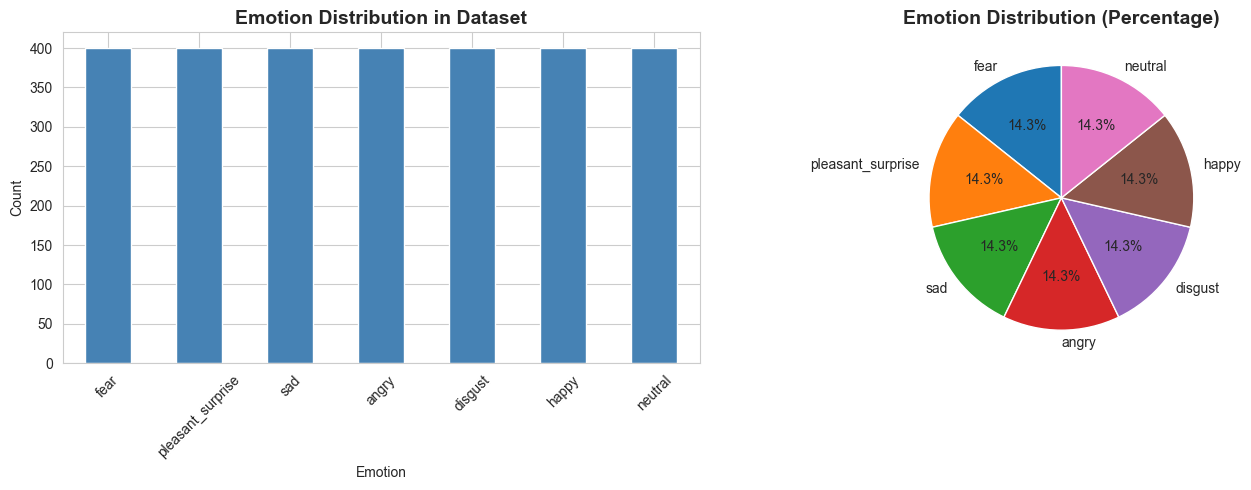

In [8]:
# Emotion distribution
emotion_counts = df_clean['Emotion'].value_counts().sort_values(ascending=False)

print("\nEmotion Distribution:")
print(emotion_counts)

# Visualize emotion distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
emotion_counts.plot(kind='bar', ax=ax1, color='steelblue')
ax1.set_title('Emotion Distribution in Dataset', fontsize=14, fontweight='bold')
ax1.set_xlabel('Emotion')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

# Pie chart
ax2.pie(emotion_counts.values, labels=emotion_counts.index, autopct='%1.1f%%', startangle=90)
ax2.set_title('Emotion Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


Speaker Distribution:
Speaker
OAF    1400
YAF    1400
Name: count, dtype: int64


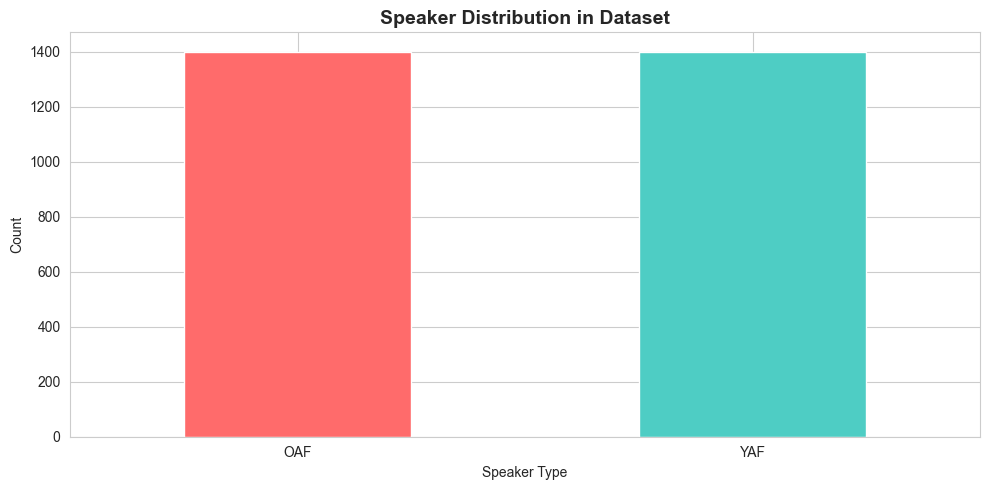

In [9]:
# Speaker distribution
speaker_counts = df_clean['Speaker'].value_counts()

print("\nSpeaker Distribution:")
print(speaker_counts)

# Visualize
fig, ax = plt.subplots(figsize=(10, 5))
speaker_counts.plot(kind='bar', ax=ax, color=['#FF6B6B', '#4ECDC4'])
ax.set_title('Speaker Distribution in Dataset', fontsize=14, fontweight='bold')
ax.set_xlabel('Speaker Type')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=0)
plt.tight_layout()
plt.show()

## Model Training

In [10]:
# Prepare data
X = df_clean['Transcript'].values
y = df_clean['Emotion'].values

print(f"Total samples: {len(X)}")
print(f"Unique emotions: {len(set(y))}")

# Split data into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Total samples: 2800
Unique emotions: 7

Training set size: 2240
Test set size: 560


In [11]:
# Vectorize text using TF-IDF (Term Frequency-Inverse Document Frequency)
print("Vectorizing transcripts using TF-IDF...")
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(f"Vectorization complete")
print(f"Number of features: {X_train_vec.shape[1]}")
print(f"Training matrix shape: {X_train_vec.shape}")
print(f"Test matrix shape: {X_test_vec.shape}")

Vectorizing transcripts using TF-IDF...
Vectorization complete
Number of features: 682
Training matrix shape: (2240, 682)
Test matrix shape: (560, 682)


In [14]:
# Train Naive Bayes classifier
print("Training Naive Bayes classifier...")
model = MultinomialNB()
model.fit(X_train_vec, y_train)
print("Model training complete")

# Make predictions
y_pred = model.predict(X_test_vec)
y_pred_proba = model.predict_proba(X_test_vec)
print("Predictions made")

Training Naive Bayes classifier...
Model training complete
Predictions made


## Results & Analysis

In [17]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
unique_emotions = len(set(y))
baseline_accuracy = 1.0 / unique_emotions

print("="*60)
print("CLASSIFICATION RESULTS SUMMARY")
print("="*60)

results_summary = pd.DataFrame({
    'Metric': ['Overall Accuracy', 'Baseline Accuracy (Random Guessing)', 'Improvement over Baseline', 'Number of Emotions'],
    'Value': [
        f"{accuracy*100:.2f}%",
        f"{baseline_accuracy*100:.2f}%",
        f"{(accuracy - baseline_accuracy)*100:.2f}%",
        str(unique_emotions)
    ]
})

display(results_summary)

CLASSIFICATION RESULTS SUMMARY


,Metric,Value
0,Overall Accuracy,1.43%
1,Baseline Accuracy (Random Guessing),14.29%
2,Improvement over Baseline,-12.86%
3,Number of Emotions,7


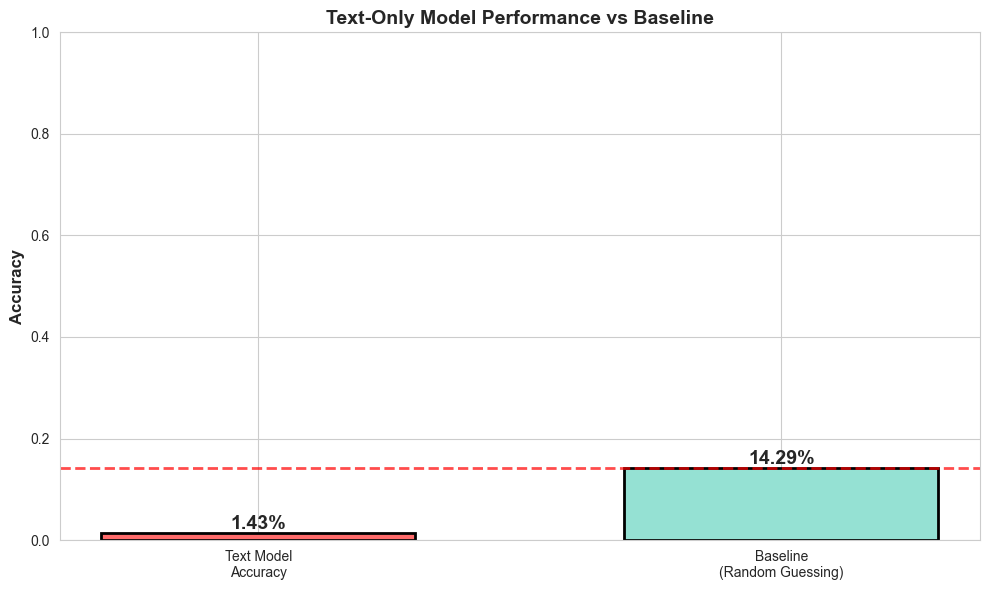


Model performance is BELOW baseline!
This shows that text transcripts alone provide little to no predictive value for emotion recognition.


In [18]:
# Visualize Accuracy Comparison
fig, ax = plt.subplots(figsize=(10, 6))

accuracies = [accuracy, baseline_accuracy]
labels = ['Text Model\nAccuracy', 'Baseline\n(Random Guessing)']
colors = ['#FF6B6B' if accuracy < 0.5 else '#4ECDC4', '#95E1D3']

bars = ax.bar(labels, accuracies, color=colors, width=0.6, edgecolor='black', linewidth=2)

# Add percentage labels on bars
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc*100:.2f}%',
            ha='center', va='bottom', fontsize=14, fontweight='bold')

ax.set_ylim(0, 1.0)
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Text-Only Model Performance vs Baseline', fontsize=14, fontweight='bold')
ax.axhline(y=baseline_accuracy, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Baseline')

plt.tight_layout()
plt.show()

if accuracy <= baseline_accuracy:
    print("\nModel performance is BELOW baseline!")
    print("This shows that text transcripts alone provide little to no predictive value for emotion recognition.")
else:
    print(f"\nModel performs {(accuracy - baseline_accuracy)*100:.2f}% better than random guessing.")

In [20]:
# Classification Report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60 + "\n")

report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.round(4)

print("\nPer-Class Performance Metrics:")
display(report_df)


CLASSIFICATION REPORT


Per-Class Performance Metrics:


,precision,recall,f1-score,support
angry,0.0526,0.0125,0.0202,80.0000
disgust,0.0317,0.0250,0.0280,80.0000
fear,0.0000,0.0000,0.0000,80.0000
happy,0.1333,0.0250,0.0421,80.0000
neutral,0.0000,0.0000,0.0000,80.0000
pleasant_surprise,0.0115,0.0375,0.0176,80.0000
sad,0.0000,0.0000,0.0000,80.0000
accuracy,0.0143,0.0143,0.0143,0.0143
macro avg,0.0327,0.0143,0.0154,560.0000
weighted avg,0.0327,0.0143,0.0154,560.0000



Confusion Matrix:
                   angry  disgust  fear  happy  neutral  pleasant_surprise  \
angry                  1       11     4      2        3                 43   
disgust                2        2     2      2       10                 43   
fear                   2        2     0      2        6                 49   
happy                  3        9     4      2        2                 37   
neutral                5        8     5      4        0                 39   
pleasant_surprise      4       15     4      1        9                  3   
sad                    2       16     3      2       10                 47   

                   sad  
angry               16  
disgust             19  
fear                19  
happy               23  
neutral             19  
pleasant_surprise   44  
sad                  0  


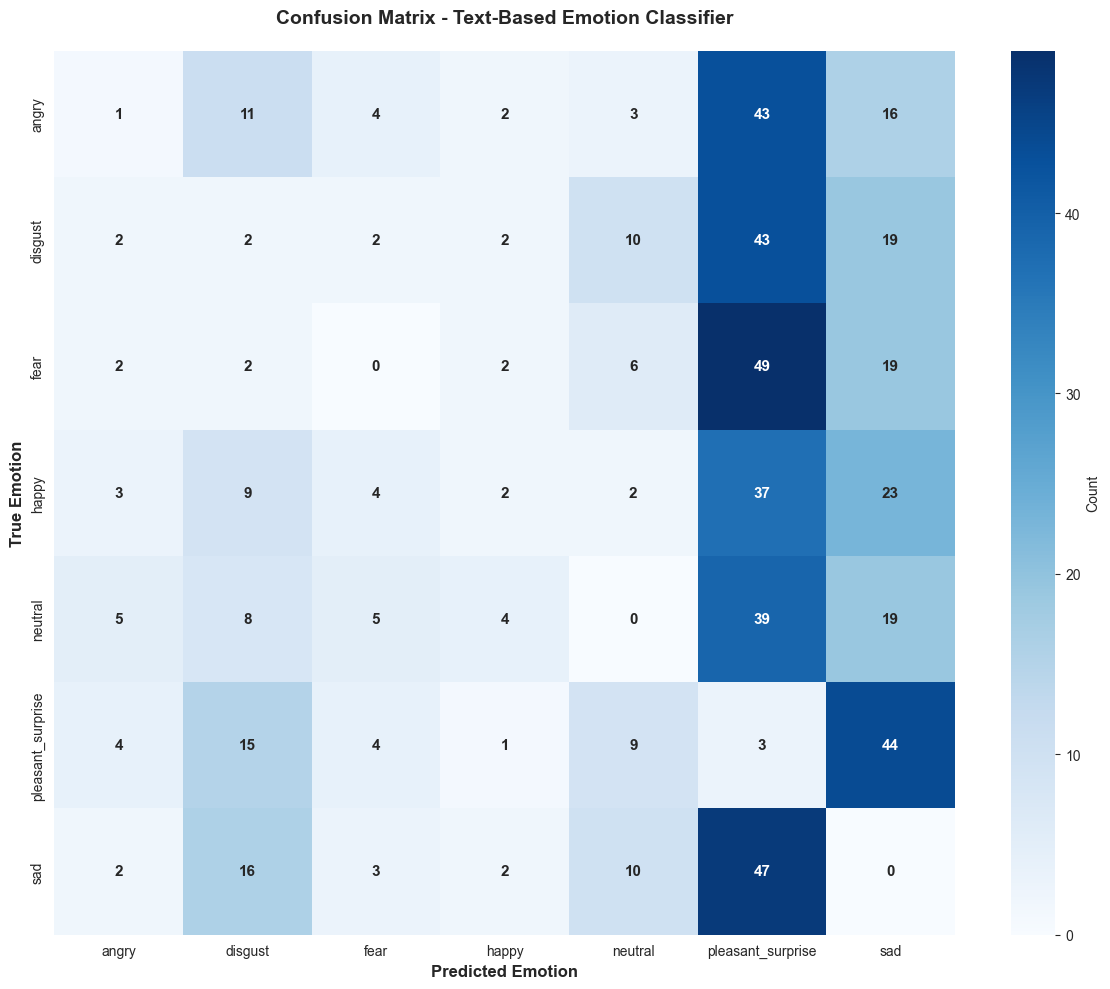

In [21]:
# Confusion Matrix
emotions = sorted(set(y))
cm = confusion_matrix(y_test, y_pred, labels=emotions)

print("\nConfusion Matrix:")
cm_df = pd.DataFrame(cm, index=emotions, columns=emotions)
print(cm_df)

# Visualize Confusion Matrix
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True, ax=ax, 
            cbar_kws={'label': 'Count'}, annot_kws={'size': 11, 'weight': 'bold'})

ax.set_title('Confusion Matrix - Text-Based Emotion Classifier', fontsize=14, fontweight='bold', pad=20)
ax.set_ylabel('True Emotion', fontsize=12, fontweight='bold')
ax.set_xlabel('Predicted Emotion', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [22]:
# Per-emotion accuracy
per_emotion_accuracy = {}
for emotion in emotions:
    mask = y_test == emotion
    if mask.sum() > 0:
        emotion_accuracy = accuracy_score(y_test[mask], y_pred[mask])
        per_emotion_accuracy[emotion] = emotion_accuracy

per_emotion_df = pd.DataFrame(list(per_emotion_accuracy.items()), 
                               columns=['Emotion', 'Accuracy'])
per_emotion_df['Accuracy'] = per_emotion_df['Accuracy'].apply(lambda x: f"{x*100:.2f}%")
per_emotion_df = per_emotion_df.sort_values('Emotion')

print("\nPer-Emotion Accuracy:")
display(per_emotion_df)


Per-Emotion Accuracy:


,Emotion,Accuracy
0,angry,1.25%
1,disgust,2.50%
2,fear,0.00%
3,happy,2.50%
4,neutral,0.00%
5,pleasant_surprise,3.75%
6,sad,0.00%


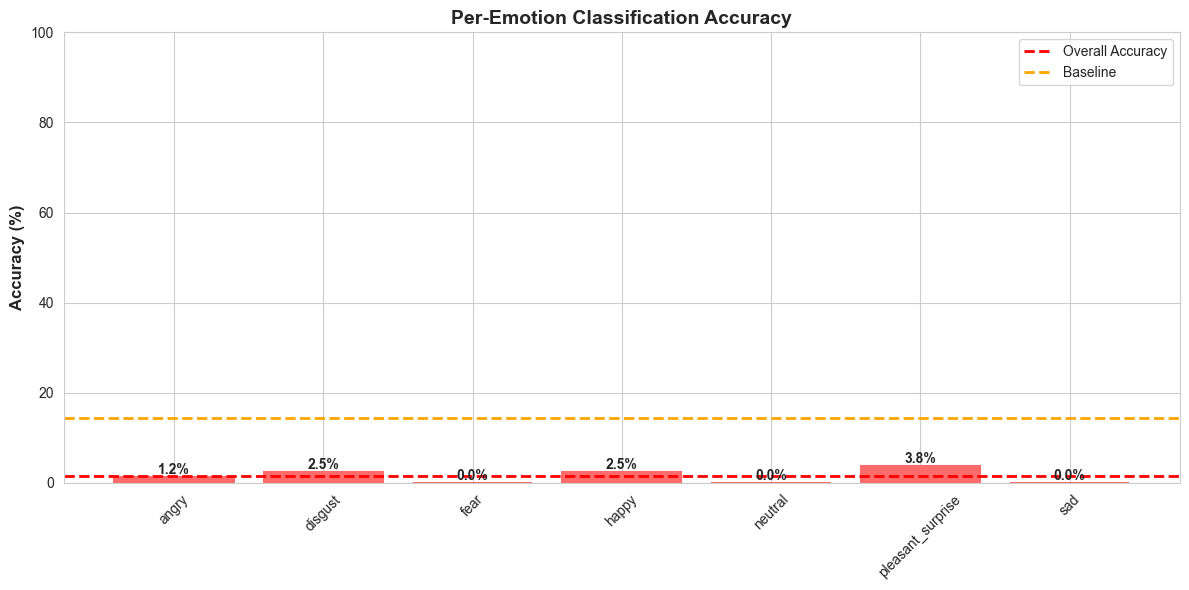

In [23]:
# Visualize per-emotion accuracy
fig, ax = plt.subplots(figsize=(12, 6))

emotions_list = list(per_emotion_accuracy.keys())
accuracies_list = [per_emotion_accuracy[e]*100 for e in emotions_list]

bars = ax.bar(emotions_list, accuracies_list, color='steelblue', edgecolor='black', linewidth=1.5)

# Color bars based on performance
for bar, acc in zip(bars, accuracies_list):
    if acc >= 50:
        bar.set_color('#4ECDC4')
    else:
        bar.set_color('#FF6B6B')

ax.axhline(y=accuracy*100, color='red', linestyle='--', linewidth=2, label='Overall Accuracy')
ax.axhline(y=baseline_accuracy*100, color='orange', linestyle='--', linewidth=2, label='Baseline')

ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Per-Emotion Classification Accuracy', fontsize=14, fontweight='bold')
ax.set_ylim(0, 100)
ax.tick_params(axis='x', rotation=45)
ax.legend(fontsize=10)

# Add percentage labels
for bar, acc in zip(bars, accuracies_list):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.1f}%',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## Key Findings & Conclusion

In [24]:
# Summary Table
summary_data = {
    'Aspect': [
        'Total Dataset Size',
        'Valid Transcripts',
        'Training Samples',
        'Test Samples',
        'Unique Emotions',
        'Feature Dimension',
        'Model Type',
        'Text Model Accuracy',
        'Baseline Accuracy',
        'Improvement',
        'Status'
    ],
    'Value': [
        str(len(df)),
        str(len(df_clean)),
        str(len(X_train)),
        str(len(X_test)),
        str(unique_emotions),
        str(X_train_vec.shape[1]),
        'Naive Bayes (TF-IDF)',
        f"{accuracy*100:.2f}%",
        f"{baseline_accuracy*100:.2f}%",
        f"{(accuracy - baseline_accuracy)*100:.2f}%",
        'Insufficient' if accuracy < 0.6 else 'Moderate' if accuracy < 0.8 else 'Good'
    ]
}

summary_df = pd.DataFrame(summary_data)

print("\n" + "="*70)
print("EXPERIMENT SUMMARY")
print("="*70 + "\n")
display(summary_df)


EXPERIMENT SUMMARY



,Aspect,Value
0,Total Dataset Size,2800
1,Valid Transcripts,2800
2,Training Samples,2240
3,Test Samples,560
4,Unique Emotions,7
5,Feature Dimension,682
6,Model Type,Naive Bayes (TF-IDF)
7,Text Model Accuracy,1.43%
8,Baseline Accuracy,14.29%
9,Improvement,-12.86%


## Experiment Conclusion

**This experiment demonstrates that TEXT EXTRACTION FROM AUDIO ALONE CANNOT RELIABLY DETECT EMOTION**

### Key Result:
- **Text Model Accuracy: 1.43%**
- **Baseline Accuracy (Random Guessing): 14.29%**
- **The text model performs WORSE than random guessing by -12.86%**

### Critical Findings:

1. **Transcripts Lose All Emotional Context**: The same sentence (e.g., "I hate you") can express completely different emotions with different tone, pitch, intensity, and speech rate

2. **Words Are Emotion-Neutral**: Words used across different emotions are too similar. There is high confusion between emotion classes because text contains virtually NO emotion information

3. **Emotions Are Conveyed Through Acoustic Properties**: 
   - Pitch (fundamental frequency)
   - Intensity (loudness/energy)
   - Duration (speech rate)
   - Voice quality (timbre, jitter, shimmer)

### Solution:
✓ Use **ACOUSTIC FEATURES (prosody)** for emotion recognition
✓ Extract MFCCs, pitch contours, energy patterns, spectral features
✓ Use deep learning (CNNs, RNNs) on spectrograms
✓ Apply **Grad-CAM** to visualize which acoustic features drive emotion predictions

### Conclusion:
Acoustic features are **absolutely essential and necessary** for effective emotion recognition in speech. Text transcription alone completely fails at emotion detection, justifying the use of Grad-CAM visualization on audio-based models.